Hikyuu 交互式工具示例
==============

1、引入交互式工具
-----------------
需从hikyuu.interactive引入，而不是直接从hikyuu库中引入（hikyuu是一个库，可用于编制其他的工具，而hikyuu.interactive.interactive是基于hikyuu库实现的交互式探索工具）

In [3]:

%matplotlib inline
%time from hikyuu.interactive import *

#use_draw_engine('echarts') #use_draw_engine('matplotlib')  #默认为'matplotlib'绘图

CPU times: total: 0 ns
Wall time: 0 ns


2、创建交易系统并运行
--------------------

In [5]:
# 创建模拟交易账户进行回测，初始资金30万
my_tm = crtTM(init_cash = 300000)

# 创建信号指示器（以5日EMA为快线，5日EMA自身的10日EMA作为慢线，快线向上穿越慢线时买入，反之卖出）
my_sg = SG_Flex(EMA(C, n=5), slow_n=10)

# 固定每次买入1000股
my_mm = MM_FixedCount(1000)

# 创建交易系统并运行
sys = SYS_Simple(tm = my_tm, sg = my_sg, mm = my_mm)
sys.run(sm['sz000001'], Query(-150))

3、绘制曲线观察
---------------

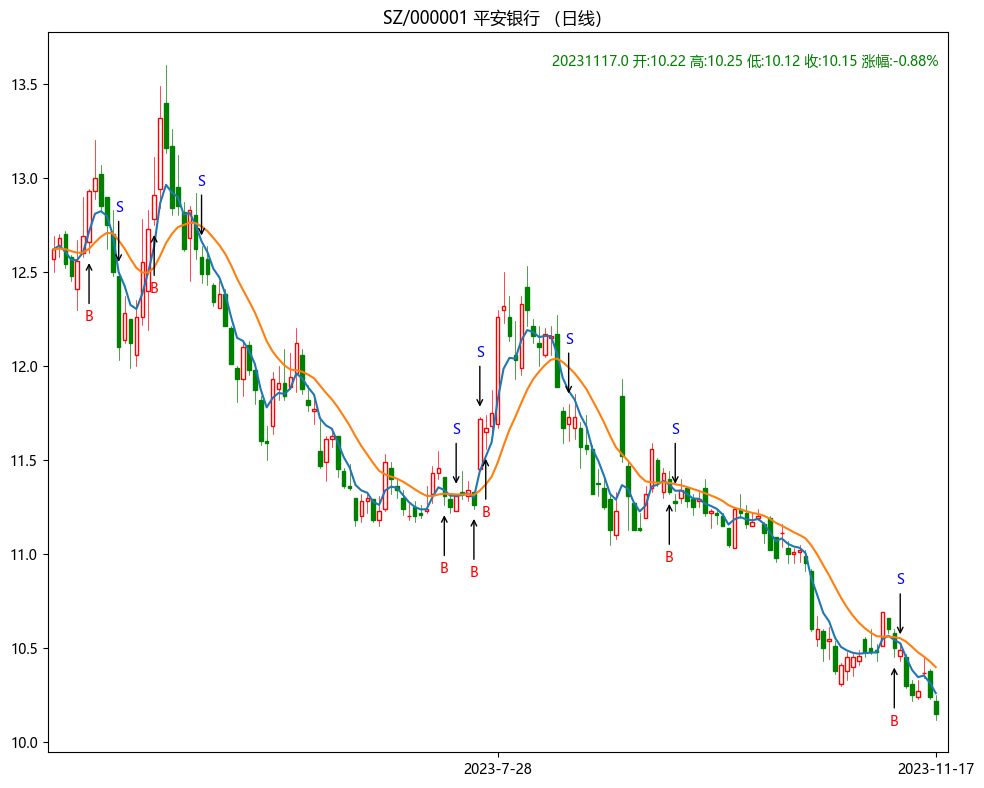

In [6]:
# 绘制系统信号
sys.plot()

k = sm['sz000001'].get_kdata(Query(-150))
c = CLOSE(k)
fast = EMA(c, 5)
slow = EMA(fast, 10)

# 绘制信号指示器使用两个指标
fast.plot(new=False)
slow.plot(new=False)

4、绘制资金收益曲线
---------------------

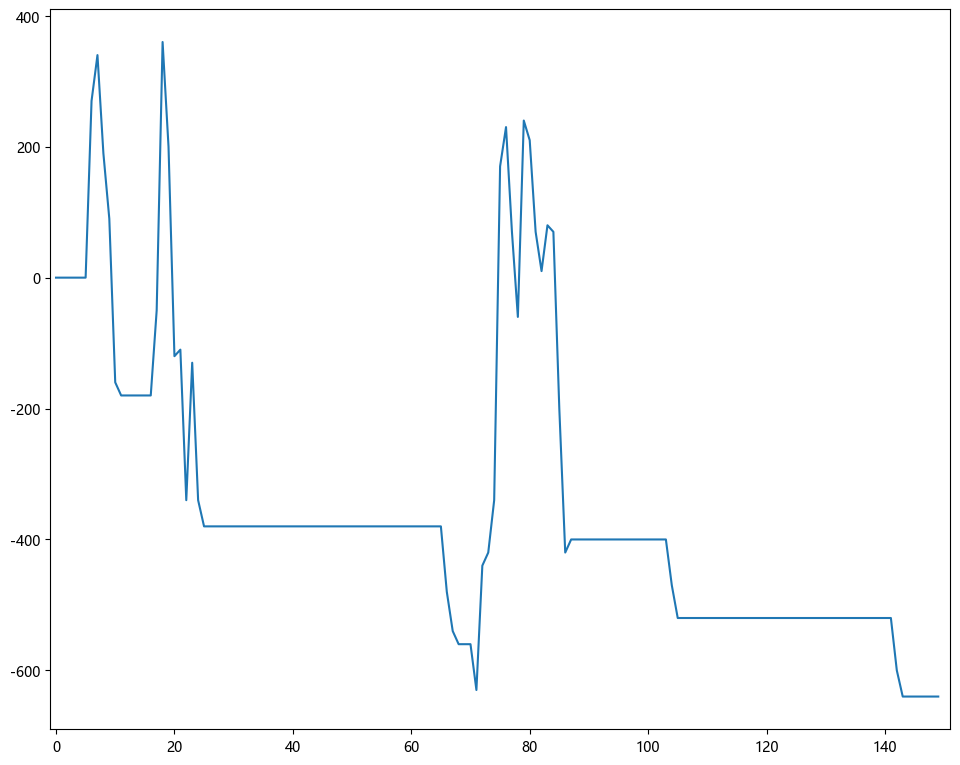

In [7]:
# 绘制资金收益曲线
x = my_tm.get_profit_curve(k.get_datetime_list(), Query.DAY)
x = PRICELIST(x)
x.plot()

5、回测统计报告
----------------------

In [8]:
# 回测统计
from datetime import datetime

per = Performance()
print(per.report(my_tm, Datetime(datetime.today())))


R乘数期望值: -0.01
亏损交易亏损总额: -800.00
亏损交易平均R乘数: -0.01
亏损交易平均亏损: -160.00
亏损交易平均持仓时间: 4.60
亏损交易数: 5.00
亏损交易最大持仓时间: 12.00
交易平均占用现金比例%: 3.90
交易机会频率/年: 11.83
净赢利/亏损比例: 0.20
单笔交易最大占用现金比例%: 4.26
已平仓交易总成本: 0.00
已平仓交易总数: 7.00
已平仓净利润总额: -640.00
已平仓帐户收益率%: -0.21
帐户初始金额: 300000.00
帐户平均年收益率%: -0.36
帐户年复合收益率%: -0.36
平均空仓时间: 24.00
平均赢利/平均亏损比例: 0.50
年度期望R乘数: -0.12
当前总资产: 299360.00
最大单笔亏损: -200.00
最大单笔亏损R乘数: -0.02
最大单笔赢利: 120.00
最大单笔赢利R乘数: 0.01
最大连续亏损R乘数: -0.02
最大连续亏损笔数: 2.00
最大连续亏损金额: -560.00
最大连续赢利R乘数: 0.00
最大连续赢利笔数: 2.00
最大连续赢利金额: 160.00
最长空仓时间: 60.00
未平仓头寸净值: 0.00
现金余额: 299360.00
空仓总时间: 173.00
空仓时间/总时间%: 79.00
累计借入现金: 0.00
累计借入资产: 0.00
累计投入本金: 300000.00
累计投入资产: 0.00
累计红利: 0.00
赢利交易平均R乘数: 0.00
赢利交易平均持仓时间: 10.50
赢利交易平均赢利: 80.00
赢利交易数: 2.00
赢利交易最大持仓时间: 20.00
赢利交易比例%: 28.57
赢利交易赢利总额: 160.00
赢利期望值: -91.43



6、关于性能
---------------

经常有人问到性能问题，下面这段的代码使用之前的系统示例，遍历指定板块的所有股票，计算他们的“盈利交易比例%”（即胜率）。

In [9]:
def test_func(stock, query):
    """计算指定stock的系统策略胜率，系统策略为之前的简单双均线交叉系统（每次固定买入100股）
    """
    #创建模拟交易账户进行回测，初始资金30万
    my_tm = crtTM(init_cash = 1000000)

    #创建信号指示器（以5日EMA为快线，5日EMA自身的10日EMA作为慢线，快线向上穿越慢线时买入，反之卖出）
    my_sg = SG_Flex(EMA(C, n=5), slow_n=10)

    #固定每次买入1000股
    my_mm = MM_FixedCount(100)

    #创建交易系统并运行
    sys = SYS_Simple(tm = my_tm, sg = my_sg, mm = my_mm)
    sys.run(stock, query)
    
    per = Performance()
    per.statistics(my_tm, Datetime(datetime.today()))
    return per["赢利交易比例%".encode('gb2312')]

def total_func(blk, query):
    """遍历指定板块的所有的股票，计算系统胜率"""
    result = {}
    for s in blk:
        if s.valid and s.type != constant.STOCKTYPE_INDEX:
            result[s.name] = test_func(s, query)
    return result

遍历所有当前有效且并非指数的证券。下面是我的机器执行结果，共计算4151支证券，最近500个交易日，共耗时2.89秒。机器配置：Intel i7-4700HQ 2.G。

In [10]:
%time a = total_func(sm, Query(-500))
len(a)

CPU times: total: 5.12 s
Wall time: 5.35 s


6445